In [273]:
import pandas as pd
import numpy as np

In [1338]:
order = 30
states = 4


transitionProbabilities = np.zeros((states, states))

transitionCounts = np.zeros((states, states))

transitionStateCounts = np.zeros(states)



In [1339]:
def jsonToDataFrame(stockData):
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []
    dates = []

    for key in stockData:
        (open_, high, low, close, volume) = stockData[key]
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        closes.append(close)
        volumes.append(volume)
        dates.append(key)

    data = {'Date':dates, 'Open':opens, 'High':highs, 'Low':lows, 'Close':closes, 'Volume': volumes}

    return pd.DataFrame(data=data)

In [1340]:



def convertArrayToTimeSeries(array, duration):
    length = len(array) - duration
    if(length <= 0):
        return np.ndarray((0,duration))

    subTimeSeries = np.ndarray((length, duration))
    for i in range(0, length):
        subTimeSeries[i] = array[i:i+duration]
    return subTimeSeries

def normalizeTimeSerie(timeSerie):
    avg = np.mean(timeSerie)
    var = np.var(timeSerie)
    if(var == 0):
        return np.zeros(timeSerie.shape)
    else:
        return (timeSerie - avg)/var

def normalizeTimeSeries(timeSeries):
    avg = np.mean(timeSeries, axis=1)
    var = np.var(timeSeries, axis=1)
    

    timeSeriesNorm = np.ndarray(timeSeries.shape)
    for i in range(len(timeSeries)):
        if(var[i] == 0):
            timeSeriesNorm[i] = np.zeros(timeSeries[i].shape)
        else:
            timeSeriesNorm[i] = (timeSeries[i] - avg[i])/var[i]
    return timeSeriesNorm




In [1341]:
from convertStockToJson import getJsonDataFromFile

def loadTimeSeriesNormalized(name):
    stockData = getJsonDataFromFile(name)
    stockDatadf = jsonToDataFrame(stockData) 
    subTimeSeries = convertArrayToTimeSeries(stockDatadf['Close'], order)
    return normalizeTimeSeries(subTimeSeries)


In [1342]:
stockNameTrainedOn = 'VAS'

subTimeSeriesNorm = loadTimeSeriesNormalized(stockNameTrainedOn)

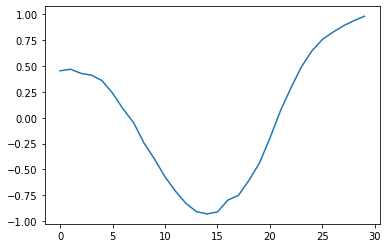

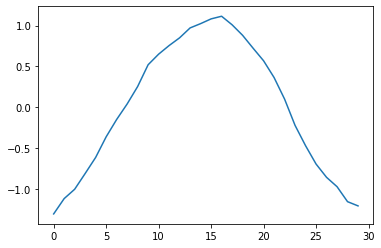

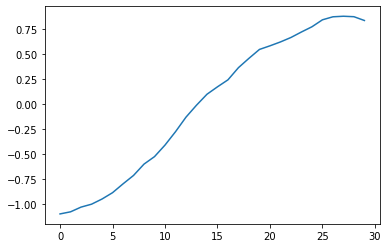

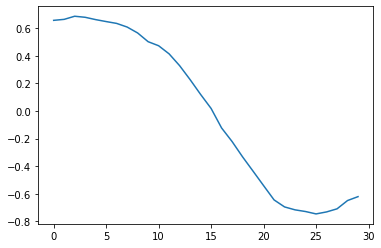

In [1343]:
from sklearn.cluster import KMeans
import numpy as np
import numpy as np
import matplotlib.pyplot as plt




kmeans = KMeans(n_clusters=states, random_state=0).fit(subTimeSeriesNorm)
cluserCenters = kmeans.cluster_centers_


for cluster in cluserCenters:
   
    plt.plot(cluster)
    plt.show()






fig, axs = plt.subplots(states, states)
fig.set_size_inches(18.5, 10.5)
for currentState in range(states):
    for nextState in range(states):
        last = cluserCenters[currentState][-1]
        dif = last - cluserCenters[nextState][0]

        clusterNextStateCopy = cluserCenters[nextState].copy()
        clusterNextStateCopy += dif

        pltData = np.concatenate((cluserCenters[currentState], clusterNextStateCopy[1:]))

        axs[currentState, nextState].axvline(x=order)
        
     

        axs[currentState, nextState].plot(pltData)

        axs[currentState, nextState].set_title('Axis ' + str(currentState) + ", " + str(nextState))

plt.plot(cluster)



In [1344]:

buysOrSells = np.zeros(states) #VAS

#buysOrSells = np.array([0.0,1,-1,-1,0,1,-0.7,0.5]) #ANZ

for i in range(states):
    buysOrSells[i] = cluserCenters[i][-1] - cluserCenters[i][0]


buysOrSells = (buysOrSells - np.mean(buysOrSells))/np.var(buysOrSells)

print(buysOrSells)
print(np.dot(transitionProbabilities, buysOrSells))


[ 0.15939687 -0.16844996  1.22903172 -1.21997864]
[0. 0. 0. 0.]


In [1345]:
subTimeSeriesClassified = kmeans.predict(subTimeSeriesNorm)

In [1390]:
def predictStateVector(timeSerieNorm):
    distances = kmeans.transform([timeSerieNorm])[0]
    minDis = np.min(distances)
    maxDis = np.max(distances)
    distances -= minDis
    distances /= maxDis
    distances = 1 - distances
    distances = distances * distances * distances
    return distances


def predictStatesVector(timeSerieNorms):
    result = np.zeros((timeSerieNorms.shape[0], states))
    for i in range(len(timeSerieNorms)):
        result[i] = predictStateVector(timeSerieNorms[i])
    return result

    distances = kmeans.transform(timeSerieNorms)
    minDis = np.min(distances, axis=1)
    maxDis = np.max(distances, axis=1)
    for i in range(len(distances)):
        distances[i] -= minDis[i]
        distances[i] /= maxDis[i]
        distances[i] = 1 - distances[i]
        distances[i] = distances[i] * distances[i] * distances[i]
    return distances
    

In [1391]:

def trainMarkokChain(subSeriesClassifified):
    for i in range(len(subSeriesClassifified)-order):
        currentState = subSeriesClassifified[i]
        nextState = subSeriesClassifified[i+order]
        
        transitionCounts[currentState, nextState] += 1
        transitionStateCounts[currentState] += 1

def trainMarkokChainContinous(timeSeriesNormalized):
    global transitionCounts, transitionStateCounts
    timeSeriesKMeanDistances = predictStatesVector(timeSeriesNormalized)

    for i in range(len(timeSeriesKMeanDistances)-order):
        
        currentState = timeSeriesKMeanDistances[i]
        nextState = timeSeriesKMeanDistances[i+order]
        nextStateMat = np.tile(nextState, (len(nextState), 1))
        adjust = (nextStateMat.transpose() * nextState).transpose()
        transitionCounts += adjust
        transitionStateCounts += np.sum(adjust, axis=1)


#trainMarkokChain(subTimeSeriesClassified)
trainMarkokChainContinous(subTimeSeriesNorm)


print(transitionCounts)
print(transitionStateCounts)

NameError: name 'state' is not defined

In [1350]:
def updateProbabilities():
    for i in range(transitionProbabilities.shape[0]):
        if(transitionStateCounts[i] != 0):
            for j in range(transitionProbabilities.shape[1]):
                transitionProbabilities[i, j] = transitionCounts[i, j]/transitionStateCounts[i]

updateProbabilities()
print(transitionProbabilities)

[[0.34590482 0.13699099 0.27134925 0.24575494]
 [0.16393858 0.31872399 0.24906796 0.26826947]
 [0.24494148 0.18787215 0.4144398  0.15274658]
 [0.22249465 0.20295483 0.1531987  0.42135182]]


In [1351]:
def loadTimeSeriesClassified(name):
    normalized = loadTimeSeriesNormalized(name)
    if(normalized.shape[0] > 0):
        return (kmeans.predict(normalized), True)
    else:
        return (None, False)

In [1352]:
def testMarkovChain(subSeriesClassifified):
    numCorrect = 0
    length = len(subSeriesClassifified)-order
    for i in range(length):
        currentState = subSeriesClassifified[i]
        nextStateCorrect = subSeriesClassifified[i+order]
        nextStatePredict = np.argmax(transitionStateCounts[currentState])
        if(nextStatePredict == nextStateCorrect):
            numCorrect += 1
    if(length > 0):
        return numCorrect/length
    else:
        return None

In [1353]:
from filesInPath import filesInPath

filenames = filesInPath('data')
import random

# random.shuffle(filenames)
# filenames = filenames[:40]
filenames = ['VAS', 'IOO', 'XRO', 'ANZ']

for (fileName,i) in zip(filenames, range(len(filenames))):
    #fileName = fileName[:-5]
 
    (timeSeriesClassified, success) = loadTimeSeriesClassified(fileName)  
    if(success):  
        percetage = testMarkovChain(timeSeriesClassified)  
        if(percetage != None):
            print(fileName + ",  " + str(percetage * 100 ) + "%")


VAS,  19.62224554039874%
IOO,  17.31374606505771%
XRO,  15.966386554621847%
ANZ,  17.1218487394958%


In [1354]:

def shouldBuyorSells(timeSeries):
    timeSerieNorms = normalizeTimeSeries(timeSeries)
    rankings = predictStatesVector(timeSerieNorms)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells))



def shoudlBuyorSell(timeSerie):
    #currentState = kmeans.predict(normalizeTimeSeries(np.array([timeSerie])))[0]
    timeSerieNorm = normalizeTimeSeries(np.array([timeSerie]))[0]
    rankings = predictStateVector(timeSerieNorm)
    return np.dot(rankings, np.dot(transitionProbabilities, buysOrSells) )


In [1355]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False
        
        if(daysShouldWaitToSell == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0.05):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    daysShouldWaitToSell = order
                    didBuy = True


        elif(daysShouldWaitToSell == 0):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                daysShouldWaitToSell = None
                didSell = True
        else:
            daysShouldWaitToSell -= 1
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


In [1372]:
def runModelAgainst(subTimeSeries, threshold, callback=None):
    principle = 1000
    buyingPower = principle
    stocks = 0
    investedAmount = 0
    onlySellWhenHigher = False
    daysShouldWaitToSell = None
    boughtFor = None
    stopGain = 0.05
    stopLoss = -0.03

    for i in range(len(subTimeSeries)):
        stockPrice = subTimeSeries[i][-1]
        stockPosition = stocks*stockPrice
        stockAmount = int(buyingPower/stockPrice)
        cost = stockAmount * stockPrice 

        signal = shoudlBuyorSell(subTimeSeries[i])
        didBuy = False
        didSell = False

        profitLoss =  1-stockPosition/boughtFor if boughtFor!=None else None
        
        if(boughtFor == None):
            if(signal > threshold):
                #should buy
                if(stockAmount > 0.05):
                    #buy
                    investedAmount += cost
                    buyingPower -= cost
                    stocks += stockAmount
                    didBuy = True
                    boughtFor = cost


        elif(profitLoss > stopGain or profitLoss < stopLoss):
            #should sell
            if(stocks > 0): # and (investedAmount < stockPosition or not onlySellWhenHigher)):
                investedAmount -= stockPosition
                buyingPower += stockPosition
                stocks = 0
                boughtFor = None
                didSell = True
        
        if(callback != None):
            callback((i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal))

    buyingPower += stocks*stockPrice
    stocks = 0

    return buyingPower


In [1373]:
def thresholdRange(subTimeSeries, steps = 20):
    signals = np.ndarray((len(subTimeSeries)))
   
    for i in range(len(subTimeSeries)):
        signals[i] = shoudlBuyorSell(subTimeSeries[i])
   
    minSig = np.min(signals)
    maxSig = np.max(signals)
    return np.arange(minSig, maxSig, (maxSig-minSig)/steps)



In [1374]:

stockPriceHistory = jsonToDataFrame(getJsonDataFromFile(stockNameTrainedOn))['Close'][-600:]
subTimeSeries = convertArrayToTimeSeries(stockPriceHistory, order)


In [1375]:


bestthreshold = -np.inf
bestPrice = -np.inf
for threshold in thresholdRange(subTimeSeries):
    price = runModelAgainst(subTimeSeries, threshold)
    if(bestPrice < price):
        bestPrice = price
        bestthreshold = threshold
    print((price, threshold))

(1035.1400000000003, -0.32728734410109767)
(982.0500000000006, -0.2930268475921167)
(980.4200000000001, -0.2587663510831358)
(882.5599999999996, -0.22450585457415484)
(909.4899999999998, -0.1902453580651739)
(911.6999999999997, -0.15598486155619296)
(937.2999999999996, -0.12172436504721201)
(849.6800000000003, -0.08746386853823107)
(990.72, -0.05320337202925013)
(898.5400000000004, -0.018942875520269187)
(862.56, 0.015317620988711755)
(886.0899999999997, 0.0495781174976927)
(901.8599999999997, 0.08383861400667364)
(849.2599999999998, 0.11809911051565458)
(908.8599999999993, 0.15235960702463552)
(822.5999999999999, 0.1866201035336164)
(771.7099999999999, 0.2208806000425974)
(782.3000000000002, 0.2551410965515784)
(751.2300000000002, 0.2894015930605593)
(781.0699999999998, 0.3236620895695402)


In [1376]:
bestthreshold = 0.3236620895695402

In [1377]:

equity = np.zeros(len(subTimeSeries))
monies = np.zeros(len(subTimeSeries))
stockOverTime = np.zeros(len(subTimeSeries))
buys = []
sells = []
stockPrices = []
signals = []
def record(state):
    (i, didBuy, didSell, buyingPower, stocks, investedAmount, daysShouldWaitToSell, stockPrice, stockPosition, stockAmount, cost, signal) = state
    buys.append(stockPrice if didBuy else None)
    sells.append(stockPrice if didSell else None)
    stockPrices.append(stockPrice)
    signals.append(signal)
    equity[i] = buyingPower + stocks*stockPrice
    monies[i] = buyingPower
    stockOverTime[i] = stocks*stockPrice

runModelAgainst(subTimeSeries, bestthreshold, record)


781.0699999999998

In [1378]:
for i in range(10):
    timeSerieNorm = normalizeTimeSeries(np.array([subTimeSeries[i]]))[0]
    print(subTimeSeries[i])
    print(predictStateVector(timeSerieNorm))
    print(shoudlBuyorSell(subTimeSeries[i]))
    print()

[71.85 72.02 71.84 71.83 72.2  71.85 71.89 72.1  72.4  72.51 72.17 71.89
 71.71 71.91 71.65 71.34 71.09 70.54 70.08 69.63 69.7  69.96 69.06 69.65
 69.13 69.23 68.41 67.9  68.02 67.63]
[0.03968564 0.16417604 0.00781049 1.        ]
-0.32728734410109767

[72.02 71.84 71.83 72.2  71.85 71.89 72.1  72.4  72.51 72.17 71.89 71.71
 71.91 71.65 71.34 71.09 70.54 70.08 69.63 69.7  69.96 69.06 69.65 69.13
 69.23 68.41 67.9  68.02 67.63 67.16]
[0.03778398 0.12513217 0.00528342 1.        ]
-0.32634478522031

[71.84 71.83 72.2  71.85 71.89 72.1  72.4  72.51 72.17 71.89 71.71 71.91
 71.65 71.34 71.09 70.54 70.08 69.63 69.7  69.96 69.06 69.65 69.13 69.23
 68.41 67.9  68.02 67.63 67.16 67.4 ]
[0.0361549  0.09542106 0.00347302 1.        ]
-0.32560227715574586

[71.83 72.2  71.85 71.89 72.1  72.4  72.51 72.17 71.89 71.71 71.91 71.65
 71.34 71.09 70.54 70.08 69.63 69.7  69.96 69.06 69.65 69.13 69.23 68.41
 67.9  68.02 67.63 67.16 67.4  67.18]
[0.03613308 0.07250669 0.00236529 1.        ]
-0.32485313599228

[]

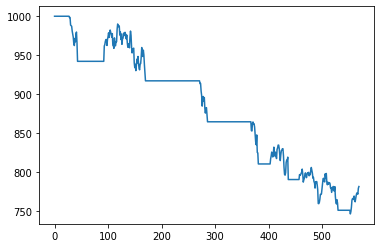

In [1379]:
plt.plot(equity)
plt.plot()

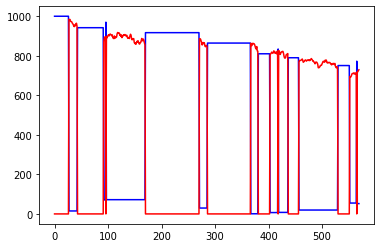

In [1380]:
plt.plot(monies, c='blue')
plt.plot(stockOverTime, c='red')
plt.show()

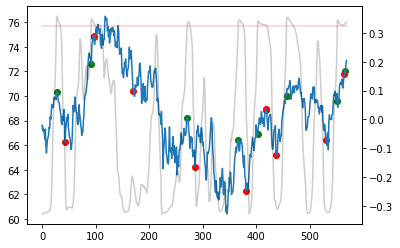

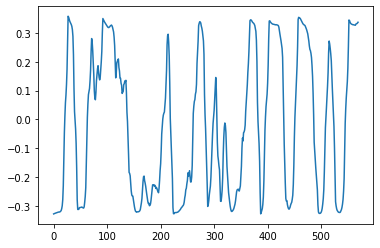

In [1381]:

fig,ax = plt.subplots()
ax.plot(stockPrices)
ax.scatter(np.arange(len(buys)), buys, c='green')
ax.scatter(np.arange(len(sells)), sells, c='red')
ax2=ax.twinx()
ax2.plot(signals,c='black', alpha=0.2)
ax2.plot([0, len(signals)-1], [bestthreshold, bestthreshold], c='red', alpha=0.2)
fig.show()
plt.show()

plt.plot(signals)
plt.show()


0


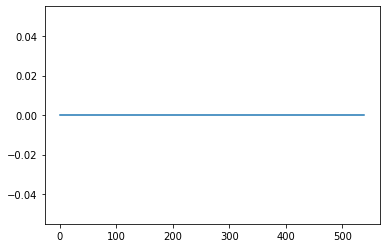

In [1382]:
buys = []
sells = []
stockPrices = []
signals = []
profits = []

daysShouldWaitToSell = None


for i in range(len(subTimeSeries) - order):
    stockPrice = subTimeSeries[i][-1]
    stockPriceFuture = subTimeSeries[i+order][-1]
    signal = shoudlBuyorSell(subTimeSeries[i])

    buys.append(None)
    sells.append(None)
    stockPrices.append(stockPrice)
    signals.append(signal)
    profits.append(0)
    if(signal > 1.8):
        #buy
        buys[i] = stockPrice  
        profit = stockPriceFuture - stockPrice
        profits[i] = profit


print(np.sum(profits))
plt.plot(profits)
plt.show()